In [2]:
# Required libraries
import os
import math
import pims
from natsort import natsorted
import torch
import torch.nn as nn
import random
import cv2 as cv
import numpy as np
import pandas as pd
import skimage as ski
from PIL import Image
import statistics
from PIL.ExifTags import TAGS
import matplotlib.pyplot as plt
from tqdm import tqdm # for calculating mean, stdev (https://kozodoi.me/blog/20210308/compute-image-stats)
from itertools import islice # for taking first n elements from an iterable (dataloader object)
from torchinfo import summary

from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import models
from torchvision.io import read_image
from torchvision.utils import save_image
from torch.utils.checkpoint import checkpoint
from torchvision.transforms import v2 as transforms

from transformers import AutoModel

from pythae.models import AE, AEConfig, AutoModel
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.celeba import Encoder_ResNet_AE_CELEBA, Decoder_ResNet_AE_CELEBA, Encoder_Conv_AE_CELEBA, Decoder_Conv_AE_CELEBA
from pythae.data.datasets import DatasetOutput
from pythae.samplers import NormalSampler

os.environ['JAVA_HOME'] = '/hps/nobackup/birney/users/esther/Fiji.app/java/linux-amd64/zulu8.60.0.21-ca-fx-jdk8.0.322-linux_x64/jre/'

In [3]:
! module load cuda/12.2.0

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(torch.version.cuda)

12.1


In [5]:
torch.manual_seed(1)

In [6]:
# Set working directory
os.chdir('/nfs/research/birney/users/esther/medaka-img/src_files/')

### Define the model

In [177]:
model_config = AEConfig(input_dim=(3, 64, 64), latent_dim=64)

model = AE(
    model_config=model_config,
    encoder=Encoder_Conv_AE_CELEBA(model_config), 
    decoder=Decoder_Conv_AE_CELEBA(model_config) 
)

summary(model, input_size=(1, 3, 64, 64))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [170]:
model_config = AEConfig(input_dim=(3, 244, 244), latent_dim=64)

encoder=Encoder_Conv_AE_CELEBA(model_config)
decoder=Decoder_Conv_AE_CELEBA(model_config)


model = AE(
    model_config=model_config,
    encoder=Encoder_Conv_AE_CELEBA(model_config), 
    decoder=Decoder_Conv_AE_CELEBA(model_config) 
)

print(model)

AE(
  (decoder): Decoder_Conv_AE_CELEBA(
    (layers): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=64, out_features=65536, bias=True)
      )
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (4): Sequential(
        (0): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(1,

In [171]:
# Replace last layer of encoder model with a new layer (to take 244 x 244 images)
encoder_layers = list(encoder.children())
encoder_layers[-1] = nn.Linear(in_features=238144, out_features = 64, bias = True)
# print(encoder_layers)
# encoder_layers.append(nn.Linear(in_features=238144, out_features = 64, bias = True))
# encoder = nn.Sequential(*encoder_layers)
# model.encoder = encoder
# print(model.encoder)

# Replace first layer of decoder model with a new layer (to take 244 x 244 images)
decoder_layers = list(decoder.children())
decoder_layers[0][0] = nn.Sequential(nn.Linear(in_features=64, out_features=952576, bias=True))
# new_layer = nn.Sequential(nn.Linear(in_features=64, out_features=952576, bias=True))
# decoder_layers.insert(0, new_layer)
# decoder = nn.Sequential(*decoder_layers)
# model.decoder = decoder

# summary(model, input_size=(3, 244, 244))

# first_conv_layer = nn.Linear(in_features=59536, out_features = 64, bias = True)
# print(first_conv_layer)
# module = list(first_conv_layer))
# print(module)
# print(list(first_conv_layer)[:-1] = nn.Linear(in_features=59536, out_features = 64, bias = True))

# # Create a new Conv2d layer with the same parameters as the first one, but with a stride of (2,2)
# new_conv_layer = torch.nn.Conv2d(first_conv_layer.in_channels, first_conv_layer.out_channels, first_conv_layer.kernel_size, stride=(2,2))

# # Replace the first Conv2d layer with the new one
# resnet[0][0] = new_conv_layer

In [172]:
print(encoder_layers)
print(decoder_layers) 

[ModuleList(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
), Linear(in_features=238144, out_features=64, bias=True)]
[ModuleList(
  (0): Sequential(
    (0): Linear(in_features=64, out_features=952576, bias=True)
  )
  (1

In [175]:
model.encoder.modules = nn.Sequential(*encoder_layers)
model.decoder.modules = nn.Sequential(*decoder_layers)

In [139]:
# class Conv_AE_CELEBA_244(nn.Module):
#     def __init__(self, model_config):
#         super(Conv_AE_CELEBA_244, self).__init__()
#         self.encoder = encoder(model_config)
#         self.decoder = decoder(model_config)

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x

In [112]:
summary(model, input_size=(1, 3, 244, 244))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [ ]:
resnet = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet101', pretrained=True)
print("Raw resnet architecture")
print(resnet)

modules = list(resnet.children())[:-1] # remove last layer
resnet = torch.nn.Sequential(*modules)
print("New resnet architecture")
print(resnet)

In [9]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        # Encoder: linear layer followed by Relu activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(980 * 1392, 4060),
            torch.nn.ReLU(),
            torch.nn.Linear(4060, 812),
            torch.nn.ReLU(),
            torch.nn.Linear(812, 203)
        )
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(203, 812),
            torch.nn.ReLU(),
            torch.nn.Linear(812, 4060),
            torch.nn.ReLU(),
            torch.nn.Linear(4060, 980 * 1392),
            torch.nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [10]:
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
 
# Using an Adam Optimizer with lr = 0.1
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

### Load data

### Define image transformations

In [7]:
# Custom min-max scaling function to pass into Compose; transforms pixel values to range [0,1] for each image individually
class MinMaxScaling:
    def __call__(self, tensor):
        return (tensor - tensor.min()) / (tensor.max() - tensor.min())

In [8]:
# Compose image transformations
# Based on testing below, MinMax scaling is the best normalization method for this dataset
# Using mean and std of the dataset for normalization is maybe not representative of the entire dataset,
# as the maximum value after normalization is 431.33228 (eg. subtracting the max pixel value, )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda img: transforms.functional.crop(img, 0, 0, 980, 1392)), # crop out bottom text
    transforms.RandomCrop(244), # crop to 64x64
    # transforms.Normalize(mean=(0, 0, 0), std=(1, 1, 1)) # temporarily, to get the mean and stdev of the dataset
    # transforms.Normalize(mean=(0.035028, 0.000052371, 0.00043022), std=(0.0600, 0.0013, 0.0028))
    # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # imagenet normalization -> returns black images
    MinMaxScaling() # custom normalization
])

/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


#### Read in the dataframe which specifies whether the fish is left- or right-facing
Used to flip all left-facing images to the right within the MedakaDataset class

In [9]:
# Read in dataframe indicating whether the fish is facing left or right
fish_direction_df= pd.read_csv("/nfs/research/birney/users/esther/medaka-img/scripts/left-facing-fish.csv")

# Only keep rows where the fish is facing left
fish_left_df = fish_direction_df[fish_direction_df['left_facing'] == 'left']
fish_left_df = fish_left_df.rename(columns={'Unnamed: 0': 'img_name'})

### Define a custom Dataset class for the medaka images

In [10]:
class MedakaDataset(Dataset):
    def __init__(self, csv_file, src_dir, transform=transform):
        self.image_paths = pd.read_csv(csv_file)['img_name']
        self.src_dir = src_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_name = self.image_paths[idx]
        img_path = f'{self.src_dir}/{img_name}'
                
        image = ski.io.imread(img_path)

        # Convert to tensor, crop out bottom text, and normalize
        if self.transform is not None:
            image = self.transform(image)

        # If facing left, flip the image horizontally
        if os.path.splitext(img_name)[0] in fish_left_df['img_name'].values:
            image = transforms.functional.hflip(image)
        
        return DatasetOutput(data=image) # for pythae

In [13]:
# Load datasets
dataset = MedakaDataset(csv_file='train_set_2024-10-03.csv', 
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/train_2024-10-03/raw_images', 
                                transform=transform)
test_dataset = MedakaDataset(csv_file='test_set_2024-10-03.csv',
                                src_dir='/nfs/research/birney/users/esther/medaka-img/src_files/test_2024-10-03/raw_images',
                                transform=transform)

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [15]:
train_len = int(len(dataset) * 0.8)
val_len = len(dataset) - train_len

print(f"Train length: {train_len}")
print(f"Validation length: {val_len}")

Train length: 889
Validation length: 223


In [16]:
train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

torch.Size([3, 244, 244])


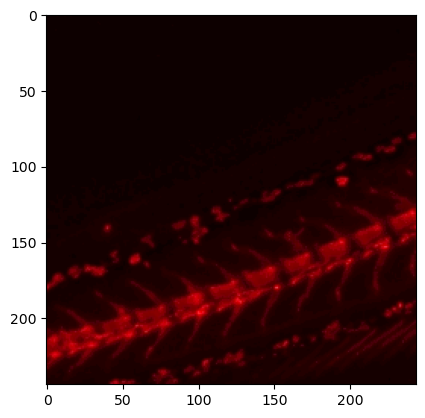

In [18]:
train_example = train_dataset[393]

print(train_example.data.shape)
plt.imshow(train_example.data.permute(1, 2, 0))

### Train Pythae model

In [176]:
training_config = BaseTrainerConfig(
    output_dir='celeba-convnet244-test',
    learning_rate=1e-3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    steps_saving=None,
    num_epochs=50)

pipeline = TrainingPipeline(
    model=model,
    training_config=training_config)

pipeline(
    train_data=train_dataset,
    eval_data=val_dataset
)

Checking train dataset...
Checking eval dataset...
Using Base Trainer



ModelError: Error when calling forward method from model. Potential issues: 
 - Wrong model architecture -> check encoder, decoder and metric architecture if you provide yours 
 - The data input dimension provided is wrong -> when no encoder, decoder or metric provided, a network is built automatically but requires the shape of the flatten input data.
Exception raised: <class 'RuntimeError'> with message: mat1 and mat2 shapes cannot be multiplied (64x230400 and 16384x64)

### Take a look at the trained model
https://github.com/clementchadebec/benchmark_VAE/blob/main/examples/notebooks/custom_dataset.ipynb

In [27]:
last_training = sorted(os.listdir('celeba-resnet-test'))[-1]
print(last_training)
trained_model = AutoModel.load_from_folder(os.path.join('celeba-resnet-test', last_training, 'final_model'))

AE_training_2024-10-09_13-17-37


FileNotFoundError: [Errno 2] No such file or directory: 'celeba-resnet-test/AE_training_2024-10-09_13-17-37/final_model/model_config.json'

In [111]:
summary(trained_model, input_size=(1, 3, 64, 64))

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

In [20]:
normal_samper = NormalSampler(
    model=trained_model
)

In [21]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

torch.Size([3, 64, 64])


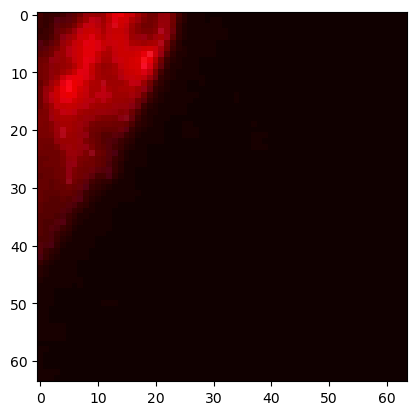

In [19]:
train_example = train_dataset[393]

print(train_example.data.shape)
plt.imshow(train_example.data.permute(1, 2, 0))

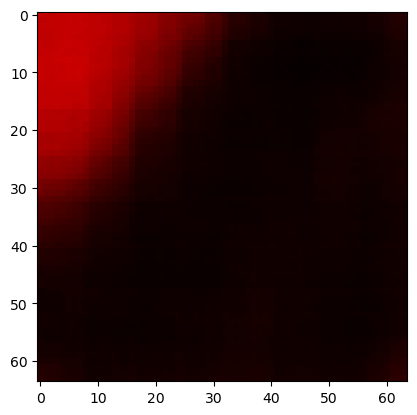

In [20]:
# Test reconstruction of above image on trained model (with cropping images to 64 x 64)
trained_model.eval()

trained_model = trained_model.to(device)
train_example.data = train_example.data.to(device)

# print(train_example.data.unsqueeze(0))
embedding = trained_model.encoder(train_example.data.unsqueeze(0))
out = trained_model.decoder(embedding.embedding)

# plt.imshow(out.reconstruction.detach().cpu().numpy().reshape(64, 64, 3))
plt.imshow(out.reconstruction.detach().cpu().squeeze(0).permute(1, 2, 0))  # .shape # .reshape(3, 64, 64)

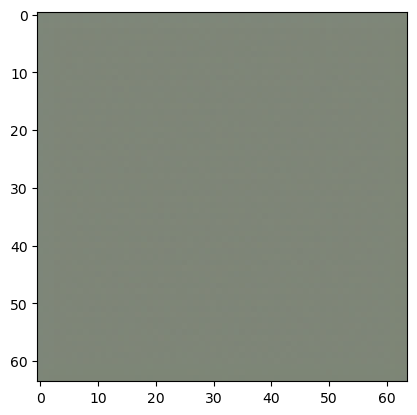

In [167]:
# Test reconstruction of above image on untrained(?) model
model.eval()

model = model.to(device)
train_example.data = train_example.data.to(device)

embedding = model.encoder(train_example.data.unsqueeze(0))
out = model.decoder(embedding.embedding)

plt.imshow(out.reconstruction.detach().cpu().squeeze(0).permute(1, 2, 0))

### Train the (custom, not pretrained) model

In [17]:
epochs = 20
outputs = []
losses = []
for epoch in range(epochs):
    for (image, _) in loader:
      # Randomly rotate the image
      image = transforms.RandomRotation(degrees=45)(image)
      print('Image rotated')

      # Reshaping the image to (-1, 784)
      image = image.reshape(-1, 980 * 1392)
      print('Image reshaped')
       
      # Output of Autoencoder
      image.requires_grad_()

      reconstructed = checkpoint(model, image)
      print('Run through model')
       
      # Calculating the loss function
      loss = loss_function(reconstructed, image)
      print('Loss calculated: ', loss)
       
      # The gradients are set to zero,
      # the gradient is computed and stored.
      # .step() performs parameter update
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      print('Backpropagation done')
       
      # Storing the losses in a list for plotting
      losses.append(loss)
    outputs.append((epochs, image, reconstructed))

Image rotated
Image reshaped


/hps/software/users/birney/esther/micromamba/envs/indigene-img/lib/python3.9/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Run through model
Loss calculated:  tensor(0.2351, grad_fn=<MseLossBackward0>)


: 

In [ ]:
# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
 
# Plotting the last 100 values
plt.plot(losses[-100:])